In [94]:
from __future__ import annotations
import jax
import jax.numpy as jnp

from jax.random import PRNGKey, multivariate_normal

import pyhf
import matplotlib.pyplot as plt
import numpy as np
from functools import partial

from typing import Callable, Any
import jaxopt
import optax

pyhf.set_backend("jax", default=True)


def make_model(pars: jnp.array) -> pyhf.Model:
    bounded_pars_upper = jnp.where(pars > 10.0, 10.0, pars)
    bounded_pars = jnp.where(bounded_pars_upper < -10.0, -10.0, bounded_pars_upper)

    u1, d1 = bounded_pars
    u = jnp.array([u1, -u1])
    d = jnp.array([d1, -d1])

    sig = jnp.array([5, 11])
    nominal = jnp.array([50, 50])
    up = jnp.array([50, 50]) + u
    down = jnp.array([50, 50]) + d

    m = {
        "channels": [
            {
                "name": "singlechannel",
                "samples": [
                    {
                        "name": "signal",
                        "data": sig,
                        "modifiers": [
                            {"name": "mu", "type": "normfactor", "data": None}
                        ],
                    },
                    {
                        "name": "background",
                        "data": nominal,
                        "modifiers": [
                            {
                                "name": "bkguncrt",
                                "type": "histosys",
                                "data": {"hi_data": up, "lo_data": down},
                            }
                        ],
                    },
                ],
            }
        ]
    }
    return pyhf.Model(m, validate=False)


def fisher_info_covariance(
    bestfit_pars: jnp.array, model: pyhf.Model, observed_data: jnp.array
) -> jnp.array:
    return jnp.linalg.inv(
        jax.hessian(lambda lhood_pars: -model.logpdf(lhood_pars, observed_data)[0])(
            bestfit_pars
        )
    )


def gaussian_logpdf(
    bestfit_pars: jnp.array, data: jnp.array, cov: jnp.array
) -> jnp.array:
    return jax.scipy.stats.multivariate_normal.logpdf(data, bestfit_pars, cov).reshape(
        1
    )


# @partial(jax.jit, static_argnames=["m"])
def model_gaussianity(
    model: pyhf.Model,
    bestfit_pars: jnp.array,
    cov_approx: jnp.array,
    observed_data: jnp.array,
) -> jnp.array:
    # - compare the likelihood of the fitted model with a gaussian approximation that has the same MLE (fitted_pars)
    # - do this across a number of points in parspace (sampled from the gaussian approx) and take the mean squared diff
    # - centre the values wrt the best-fit vals to scale the differences
    gaussian_parspace_samples = multivariate_normal(
        key=PRNGKey(1), mean=bestfit_pars, cov=cov_approx, shape=(100,)
    )

    relative_nlls_model = jax.vmap(
        lambda pars, data: -(
            model.logpdf(pars, data)[0] - model.logpdf(bestfit_pars, data)[0]
        ),  # scale origin to bestfit pars
        in_axes=(0, None),
    )(gaussian_parspace_samples, observed_data)

    relative_nlls_gaussian = jax.vmap(
        lambda pars, data: -(
            gaussian_logpdf(pars, data, cov_approx)[0]
            - gaussian_logpdf(bestfit_pars, data, cov_approx)[0]
        ),  # data fixes the lhood shape
        in_axes=(0, None),
    )(gaussian_parspace_samples, bestfit_pars)

    diffs = relative_nlls_model - relative_nlls_gaussian
    return jnp.mean(diffs[jnp.isfinite(diffs)] ** 2, axis=0)


def make_fit_objective(
    data: jnp.array, model: pyhf.Model, poi_condition: float | None = None
):
    def fit_objective(lhood_pars_to_optimize: jnp.array) -> float:  # NLL
        """lhood_pars_to_optimize: either all pars, or just nuisance pars"""
        poi_idx = model.config.poi_index
        poi = poi_condition or lhood_pars_to_optimize[poi_idx]
        pars = lhood_pars_to_optimize.at[poi_idx].set(poi)
        return -model.logpdf(pars, data)[0]  # pyhf.Model.logpdf returns list[float]

    return fit_objective


# try wrapping obj with closure_convert
@partial(jax.jit, static_argnames=["objective_fn"])
def _minimize(objective_fn, init_pars, lr=4e-3):
    converted_fn, aux_pars = jax.closure_convert(objective_fn, init_pars)
    # aux_pars seems to be empty? took that line from jax docs example...
    solver = jaxopt.OptaxSolver(
        fun=converted_fn, opt=optax.adam(lr), implicit_diff=True
    )
    return solver.run(init_pars, *aux_pars)[0]


# @partial(jax.jit, static_argnames = ["model", "poi_condition"])
def fit(
    data: jnp.array,
    model: pyhf.Model,
    init_pars: jnp.array,
    poi_condition: float | None = None,
    lr: float = 4e-3,
) -> jnp.array:
    obj = make_fit_objective(data, model, poi_condition)
    # init_pars_copy = init_pars or jnp.asarray(model.config.suggested_init())
    fit_res = _minimize(obj, init_pars, lr)
    blank = jnp.zeros_like(init_pars)
    blank += fit_res
    poi_idx = model.config.poi_index
    poi = poi_condition or fit_res[poi_idx]
    return blank.at[poi_idx].set(poi)


def hypotest(
    test_poi: jnp.array, data: jnp.array, model: pyhf.Model, init_pars: jnp.array
) -> jnp.array:

    conditional_pars = fit(data, model, poi_condition=test_poi, init_pars=init_pars)
    mle_pars = fit(data, model, init_pars=init_pars)

    profile_likelihood = -2 * (
        model.logpdf(conditional_pars, data)[0] - model.logpdf(mle_pars, data)[0]
    )
    poi_hat = mle_pars[model.config.poi_index]
    qmu = jnp.where(poi_hat < test_poi, profile_likelihood, 0.0)

    CLsb = 1 - pyhf.tensorlib.normal_cdf(jnp.sqrt(qmu))
    altval = 0.0
    CLb = 1 - pyhf.tensorlib.normal_cdf(altval)
    return CLsb / CLb


# @partial(jax.jit, static_argnames=["m", "bestfit_pars"])
def metrics(
    bestfit_pars: jnp.array,
    model: pyhf.Model,
    observed_data: jnp.array,
    diff_pars: jnp.ndarray,
) -> jnp.array:
    cov_approx = fisher_info_covariance(bestfit_pars, model, observed_data)
    mu_idx, y_idx = model.config.par_order.index("mu"), model.config.par_order.index(
        "bkguncrt"
    )
    mu_uncert2 = cov_approx[mu_idx, mu_idx]
    pull_width_metric2 = (1 - cov_approx[y_idx, y_idx]) ** 2
    gaussianity = model_gaussianity(model, bestfit_pars, cov_approx, observed_data)

    cls_obs = hypotest(1.0, observed_data, model, init_pars=jnp.array([0.0, 0.0]))
    return dict(
        cls_obs=cls_obs,
        mu_uncert2=mu_uncert2,
        pull_width_metric2=pull_width_metric2,
        gaussianity=gaussianity,
    )

In [95]:
def pipeline(pars: jnp.array, data: jnp.array) -> jnp.array:
    model = make_model(pars)
    all_data = jnp.concatenate((data, jnp.array(model.config.auxdata)))
    mle_pars = fit(all_data, model, jnp.array(model.config.suggested_init()))

    return jnp.array(list(metrics(mle_pars, model, all_data, pars).values()))

DeviceArray([[-0.00059334,  0.00183802],
             [-0.00261573,  0.00274211],
             [-0.01343067,  0.01261283],
             [ 0.16431752,  0.22919709]], dtype=float64)

In [23]:
import numpy as np

dense = 10
num_up, num_down = (dense, dense)

up_grid = np.linspace(-10, 10, num_up)
down_grid = np.linspace(-10, 10, num_down)

uv, dv = np.meshgrid(up_grid, down_grid)

In [24]:
pipe = partial(pipeline, data=jnp.array([50.0, 50.0]))
values = np.array([pipe(jnp.array(a)) for a in np.vstack([uv.ravel(), dv.ravel()]).T])

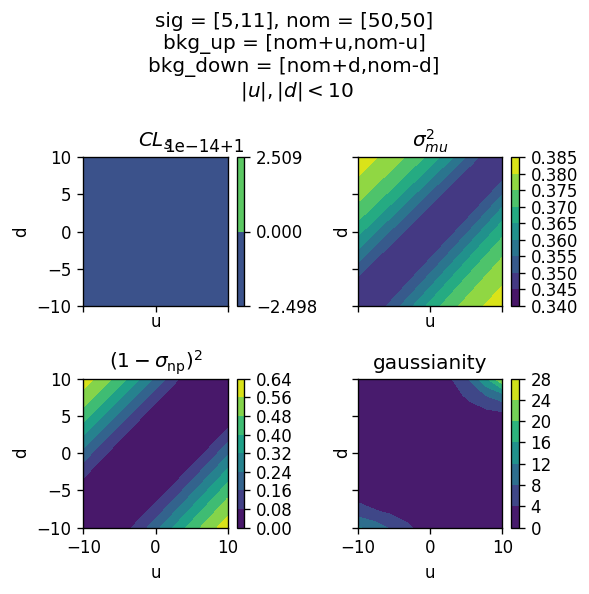

In [25]:
import matplotlib.pyplot as plt

plt.rc("figure", figsize=[5, 5], dpi=120, facecolor="w")

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)

for i, (label, ax) in enumerate(
    zip(
        ["$CL_s$", r"$\sigma_{mu}^2$", r"$(1-\sigma_{\mathsf{np}})^2$", "gaussianity"],
        axs.ravel(),
    )
):
    p = ax.contourf(uv, dv, values[:, i].reshape((dense, dense)))
    plt.colorbar(p, ax=ax)
    ax.set_xlabel("u")
    ax.set_ylabel("d")
    ax.set_title(label)

plt.suptitle(
    "sig = [5,11], nom = [50,50]\nbkg_up = [nom+u,nom-u]\nbkg_down = [nom+d,nom-d]\n $|u|, |d|<10$"
)
plt.tight_layout()